In [51]:
import pandas as pd
import re

# 데이터 불러오기
df = pd.read_excel("C:/Users/user/Desktop/이민재/전신발현프로모터/data.xlsx")

# 1. sequences에서 ATGC 외의 문자가 있으면 해당 행 삭제 (대소문자 모두)
def is_valid(seq):
    return bool(re.fullmatch(r'[ATGC]+', seq.upper()))

df = df[df['sequences'].apply(is_valid)]

# 2. sequences 중복 행 삭제
df = df.drop_duplicates(subset='sequences').reset_index(drop=True)

# 3. Endosperm, Leaf_mean, Embryo_mean 각각 10 이상이면 1, 아니면 0
for col in ['Endosperm', 'Leaf_mean', 'Embryo_mean']:
    df[col] = (df[col] >= 1).astype(int)

# 결과 확인
print(df.head())

                                           sequences  Endosperm  Leaf_mean  \
0  ATGGCATTCAACCTCATGTTAAAAATCCTTCAAATTTCCCATGAAT...          1          0   
1  ATGTGTGAGGAGATGTGTGTCCACAATTTTATGACCCTCCATCAAC...          0          0   
2  AGGATCGCTGGTCGCAAGCCGCCATTTGATCGAGTCGCGCGTGCAT...          0          0   
3  TTCCCGATACCGCCGCCCCTCTCACCAAATTCGGTCTCCTCGTTGC...          0          0   
4  ATGAAGTTCGGTGACGCCTTATGAATGTACGCGTCCTTACTGTCTC...          1          1   

   Embryo_mean  
0            0  
1            0  
2            0  
3            0  
4            0  


In [61]:
print("최소 길이:", df["seq_len"].min())
print("평균 길이:", df["seq_len"].mean())
print("중앙값:", df["seq_len"].median())
print("90% 분위수:", int(df["seq_len"].quantile(0.9)))
print("99% 분위수:", int(df["seq_len"].quantile(0.99)))
print("최대 길이:", df["seq_len"].max())

KeyError: 'seq_len'

In [63]:
for col in ['Endosperm', 'Leaf_mean', 'Embryo_mean']:
    count_1 = (df[col] == 1).sum()
    count_0 = (df[col] == 0).sum()
    print(f"{col}: 1의 개수 = {count_1}, 0의 개수 = {count_0}")

Endosperm: 1의 개수 = 22778, 0의 개수 = 43382
Leaf_mean: 1의 개수 = 19821, 0의 개수 = 46339
Embryo_mean: 1의 개수 = 23545, 0의 개수 = 42615


In [65]:
def seq_to_onehot(seq, max_length):
    base_dict = {'A':0, 'C':1, 'G':2, 'T':3}
    arr = np.zeros((max_length, 4), dtype=np.float32)
    seq = seq.upper()
    for i, base in enumerate(seq[:max_length]):
        if base in base_dict:
            arr[i, base_dict[base]] = 1.0
    # max_length보다 짧으면 자동으로 0패딩
    return arr

In [67]:
import numpy as np
max_length = 5750
X = np.stack([seq_to_onehot(seq, max_length) for seq in df['sequences']])
print("X shape:", X.shape)  # (샘플 수, max_length, 4)
y_multi = df[['Endosperm', 'Leaf_mean', 'Embryo_mean']].values

X shape: (66160, 5750, 4)


In [68]:
y = (y_multi.sum(axis=1) == 3).astype(np.float32).reshape(-1,1)  # (샘플 수, 1)
print("y shape:", y.shape)
print("Triple positive 비율:", y.mean())

y shape: (66160, 1)
Triple positive 비율: 0.20160218


In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import re
from sklearn.model_selection import train_test_split
class SequenceOnehotDataset(Dataset):
    def __init__(self, X, y):
        # X: (샘플 수, L, 4), y: (샘플 수, 1)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_onehot = self.X[idx]     # (L,4)
        label = self.y[idx]            # (1,)
        attention_mask = (input_onehot.sum(-1) > 0).long()  # (L,)
        return {
            'input_onehot': input_onehot,
            'attention_mask': attention_mask,
            'labels': label
        }

In [70]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = SequenceOnehotDataset(X_train, y_train)
val_dataset   = SequenceOnehotDataset(X_val, y_val)
test_dataset  = SequenceOnehotDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [7]:
import torch
import torch.nn as nn

class ResidualBlock1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=8, dropout=0.2):
        super().__init__()
        pad = kernel_size // 2  # 'same' padding
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad)
        self.bn1   = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad)
        self.bn2   = nn.BatchNorm1d(out_ch)
        self.drop  = nn.Dropout(dropout)

        # 채널이 바뀌면 skip를 1x1 conv로 매칭
        self.skip = (in_ch != out_ch)
        if self.skip:
            self.proj = nn.Conv1d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):  # x: (B, C, L)
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.gelu(out)
        out = self.drop(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip:
            identity = self.proj(identity)

        out = F.gelu(out + identity)
        return out

class ResidualDeepCRE_CNN(nn.Module):
    def __init__(self, input_dim=4, num_classes=1, kernel_size=8, dropout=0.2, num_blocks=4):
        super().__init__()
        channel_list = [128, 256, 256, 512, 512]  # 길이 >= num_blocks 가정
        blocks = []
        in_channels = input_dim
        for i in range(num_blocks):
            out_channels = channel_list[i]
            blocks.append(ResidualBlock1d(in_channels, out_channels, kernel_size, dropout))
            in_channels = out_channels
        self.cnn = nn.Sequential(*blocks)
        self.fc  = nn.Linear(in_channels, num_classes)

    def forward(self, input_onehot, attention_mask=None):
        """
        input_onehot: (B, L, 4)
        attention_mask: (B, L), 1=valid, 0=pad
        """
        x = input_onehot.permute(0, 2, 1)     # (B, 4, L)
        x = self.cnn(x)                       # (B, C, L)

        if attention_mask is not None:
            # conv feature에 맞게 mask 확장
            mask = attention_mask.unsqueeze(1).to(x.dtype)  # (B, 1, L)
            x = x * mask                                    # PAD 위치 0으로 제거
            summed = x.sum(dim=-1)                          # (B, C)
            counts = mask.sum(dim=-1).clamp(min=1.0)        # (B, 1) 0분모 방지
            x = summed / counts                             # masked average pooling
        else:
            # mask 없으면 일반 global mean
            x = x.mean(dim=-1)

        logits = self.fc(x)                                  # (B, num_classes)
        return logits


In [31]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, pos_weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # 클래스별 alpha(없어도 됨)
        self.pos_weight = pos_weight  # Tensor, shape=(num_classes,)
        self.reduction = reduction

    def forward(self, logits, targets):
        # BCE loss: shape (B, num_classes)
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - pt) ** self.gamma

        # pos_weight 적용 (broadcast to shape)
        if self.pos_weight is not None:
            # targets: (B, C), pos_weight: (C,) → 곱셈 가능
            focal_weight = focal_weight * (self.pos_weight.unsqueeze(0))  # (B, C)

        loss = focal_weight * BCE_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1: train_loss=0.9562, val_loss=0.9051
Best model saved!
Epoch 2: train_loss=0.8902, val_loss=1.1897
Epoch 3: train_loss=0.8637, val_loss=0.8995
Best model saved!
Epoch 4: train_loss=0.8412, val_loss=0.8420
Best model saved!
Epoch 5: train_loss=0.8250, val_loss=1.0125
Epoch 6: train_loss=0.8052, val_loss=1.1331
Epoch 7: train_loss=0.7924, val_loss=1.0909
Epoch 8: train_loss=0.7735, val_loss=0.8814
Epoch 9: train_loss=0.7607, val_loss=1.0167
Epoch 10: train_loss=0.7413, val_loss=0.8244
Best model saved!
Epoch 11: train_loss=0.7356, val_loss=0.9755
Epoch 12: train_loss=0.7160, val_loss=0.8186
Best model saved!
Epoch 13: train_loss=0.7006, val_loss=1.0576
Epoch 14: train_loss=0.6838, val_loss=0.8436
Epoch 15: train_loss=0.6713, val_loss=0.8538
Epoch 16: train_loss=0.6561, val_loss=0.9192
Epoch 17: train_loss=0.6381, val_loss=0.9603
Epoch 18: train_loss=0.6206, val_loss=1.2492
Epoch 19: train_loss=0.6050, val_loss=0.8781
Epoch 20: train_loss=0.5939, val_loss=0.9675


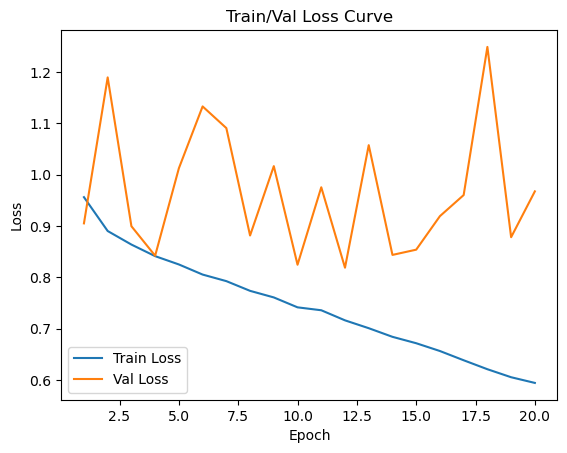

In [70]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResidualDeepCRE_CNN(
    input_dim=4,
    num_classes=1,      # 클래스 수
    kernel_size=9,      # 커널 크기
    dropout=0.4,        # 드롭아웃
    num_blocks=4        # Conv 블록 개수
).to(device)

import torch

# y_train: (N, 3) numpy 배열, 각 열이 Endosperm, Leaf_mean, Embryo_mean


#N_endosperm = df['Endosperm'].sum()
#N_leaf = df['Leaf_mean'].sum()
#N_embryo = df['Embryo_mean'].sum()

#counts = np.array([N_endosperm, N_leaf, N_embryo], dtype=np.float32)

# 클래스별 가중치 = 개수의 역수
#pw = torch.tensor(1.0 / counts, device=device, dtype=torch.float32)

# 합이 1이 되도록 정규화
#alpha_pw = pw / pw.sum()# ex: [0.254, 0.525, 0.221]
#alpha_uni = torch.tensor([1/3, 1/3, 1/3], device=device)
#lam = 0.3  # 0.2~0.5 사이 sweep
#alpha = (1-lam)*alpha_uni + lam*alpha_pw
#criterion = FocalLoss(gamma=2.0, alpha=alpha)


# pos_weight 계산 (양성 비율 20% → 약 4.0)
pos_weight_value = 4.0
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 20  # 필요에 따라 조정
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # === TRAIN ===
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        input_onehot = batch['input_onehot'].to(device)      # (B, L, 4)
        attention_mask = batch['attention_mask'].to(device)  # (B, L)
        labels = batch['labels'].to(device)                  # (B, C)

        optimizer.zero_grad(set_to_none=True)
        logits = model(input_onehot, attention_mask)         # <- 모델이 mask를 내부에서 사용
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    train_losses.append(train_loss)

    # === VALIDATION ===
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_onehot = batch['input_onehot'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_onehot, attention_mask)
            loss = criterion(logits, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / max(1, len(val_loader))
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # === BEST MODEL 저장 ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("Best model saved!")

# === Loss 그래프 ===
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train/Val Loss Curve')
plt.show()

In [72]:
import numpy as np
import torch
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, precision_recall_curve
)


# (A) 로더에서 확률/라벨 수집
def collect_probs_labels_binary(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['input_onehot'].to(device)      # (B,L,4)
            m = batch['attention_mask'].to(device)    # (B,L)
            y = batch['labels'].to(device).float()    # (B,1) or (B,)
            y = y.view(-1)                            # (B,)
            logit = model(x, m)                       # (B,)  (모델에서 squeeze(-1) 했다고 가정)
            prob = torch.sigmoid(logit).cpu().numpy() # (B,)
            all_probs.append(prob)
            all_labels.append(y.cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels).astype(int)

# (B) 이진 F1 최대화 임계값 탐색
def find_best_threshold_binary(probs, labels, t_min=0.1, t_max=0.9, steps=33):
    best_t, best_f1 = 0.5, -1.0
    for t in np.linspace(t_min, t_max, steps):
        pred = (probs >= t).astype(int)
        f1 = f1_score(labels, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# (C) 지표 계산(이진)
def binary_metrics(probs, labels, threshold):
    pred = (probs >= threshold).astype(int)
    f1   = f1_score(labels, pred, zero_division=0)
    prec = precision_score(labels, pred, zero_division=0)
    rec  = recall_score(labels, pred, zero_division=0)
    pr_auc = average_precision_score(labels, probs)  # = PR-AUC
    return {"F1": f1, "Precision": prec, "Recall": rec, "PR-AUC": pr_auc}

# (D) 전체 평가 파이프라인
def evaluate_with_threshold_search(model, val_loader, test_loader=None,
                                   t_min=0.1, t_max=0.9, steps=33, verbose=True):
    # 1) Val에서 확률/라벨 수집
    val_probs, val_labels = collect_probs_labels_binary(model, val_loader)
    # 2) 임계값 탐색 (F1 최대화)
    best_t, best_val_f1 = find_best_threshold_binary(val_probs, val_labels, t_min, t_max, steps)
    # 3) Val 지표
    val_metrics = binary_metrics(val_probs, val_labels, best_t)
    if verbose:
        print(f"[VAL] Best threshold: {best_t:.3f}")
        print(f"[VAL] F1={val_metrics['F1']:.4f}  Precision={val_metrics['Precision']:.4f}  "
              f"Recall={val_metrics['Recall']:.4f}  PR-AUC={val_metrics['PR-AUC']:.4f}")

    test_metrics = None
    if test_loader is not None:
        test_probs, test_labels = collect_probs_labels_binary(model, test_loader)
        test_metrics = binary_metrics(test_probs, test_labels, best_t)
        if verbose:
            print(f"[TEST] Using th={best_t:.3f}")
            print(f"[TEST] F1={test_metrics['F1']:.4f}  Precision={test_metrics['Precision']:.4f}  "
                  f"Recall={test_metrics['Recall']:.4f}  PR-AUC={test_metrics['PR-AUC']:.4f}")
    return best_t, val_metrics, test_metrics


In [77]:
# 1) 예전과 동일하게 모델 구성 (kernel_size=9, num_classes=3)
model = ResidualDeepCRE_CNN(input_dim=4, kernel_size=9, num_blocks=4, dropout=0.2)
# 만약 클래스 3개였던 시점의 코드라면 num_classes=3인 버전으로

# 2) 가중치 로드 (weights_only 경고 대응)
state_dict = torch.load("best_model.pt", map_location=device)  # 너가 저장한 건 state_dict임
model.load_state_dict(state_dict, strict=True)  # 구조가 완전 같아야 함
model = model.to(device)
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_12356\1499868195.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pt", map_location=device)

ResidualDeepCRE_CNN(
  (cnn): Sequential(
    (0): ResidualBlock1d(
      (conv1): Conv1d(4, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.2, inplace=False)
      (proj): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock1d(
      (conv1): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.2, inplace=False)
      (proj): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    )
  

In [81]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, precision_recall_curve,
    accuracy_score
)

# (A) 로더에서 확률/라벨 수집
def collect_probs_labels_binary(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['input_onehot'].to(device)      # (B,L,4)
            m = batch['attention_mask'].to(device)    # (B,L)
            y = batch['labels'].to(device).float()    # (B,1) or (B,)
            y = y.view(-1)                            # (B,)
            logit = model(x, m)                       # (B,)  (모델에서 squeeze(-1) 했다고 가정)
            prob = torch.sigmoid(logit).cpu().numpy() # (B,)
            all_probs.append(prob)
            all_labels.append(y.cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels).astype(int)

# (B) 이진 F1 최대화 임계값 탐색
def find_best_threshold_binary(probs, labels, t_min=0.1, t_max=0.9, steps=33):
    best_t, best_f1 = 0.5, -1.0
    for t in np.linspace(t_min, t_max, steps):
        pred = (probs >= t).astype(int)
        f1 = f1_score(labels, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# (C) 지표 계산(이진) — Accuracy 추가
def binary_metrics(probs, labels, threshold):
    pred = (probs >= threshold).astype(int)
    f1     = f1_score(labels, pred, zero_division=0)
    prec   = precision_score(labels, pred, zero_division=0)
    rec    = recall_score(labels, pred, zero_division=0)
    pr_auc = average_precision_score(labels, probs)  # = PR-AUC
    acc    = accuracy_score(labels, pred)            # = Accuracy
    return {"Accuracy": acc, "F1": f1, "Precision": prec, "Recall": rec, "PR-AUC": pr_auc}

# (D) 전체 평가 파이프라인
def evaluate_with_threshold_search(model, val_loader, test_loader=None,
                                   t_min=0.1, t_max=0.9, steps=33, verbose=True):
    # 1) Val에서 확률/라벨 수집
    val_probs, val_labels = collect_probs_labels_binary(model, val_loader)
    # 2) 임계값 탐색 (F1 최대화)
    best_t, best_val_f1 = find_best_threshold_binary(val_probs, val_labels, t_min, t_max, steps)
    # 3) Val 지표
    val_metrics = binary_metrics(val_probs, val_labels, best_t)
    if verbose:
        print(f"[VAL] Best threshold: {best_t:.3f}")
        print(f"[VAL] Acc={val_metrics['Accuracy']:.4f}  F1={val_metrics['F1']:.4f}  "
              f"P={val_metrics['Precision']:.4f}  R={val_metrics['Recall']:.4f}  "
              f"PR-AUC={val_metrics['PR-AUC']:.4f}")

    test_metrics = None
    if test_loader is not None:
        test_probs, test_labels = collect_probs_labels_binary(model, test_loader)
        test_metrics = binary_metrics(test_probs, test_labels, best_t)
        if verbose:
            print(f"[TEST] Using th={best_t:.3f}")
            print(f"[TEST] Acc={test_metrics['Accuracy']:.4f}  F1={test_metrics['F1']:.4f}  "
                  f"P={test_metrics['Precision']:.4f}  R={test_metrics['Recall']:.4f}  "
                  f"PR-AUC={test_metrics['PR-AUC']:.4f}")
    return best_t, val_metrics, test_metrics

# 사용 예시
best_t, val_m, test_m = evaluate_with_threshold_search(
    model, val_loader, test_loader,
    t_min=0.1, t_max=0.9, steps=33, verbose=True
)

[VAL] Best threshold: 0.550
[VAL] Acc=0.7887  F1=0.5789  P=0.4772  R=0.7358  PR-AUC=0.5183
[TEST] Using th=0.550
[TEST] Acc=0.7890  F1=0.5815  P=0.4882  R=0.7191  PR-AUC=0.5358


In [74]:
best_t, val_m, test_m = evaluate_with_threshold_search(
    model, val_loader, test_loader,
    t_min=0.1, t_max=0.9, steps=33, verbose=True
)

[VAL] Best threshold: 0.775
[VAL] F1=0.5694  Precision=0.4567  Recall=0.7557  PR-AUC=0.5128
[TEST] Using th=0.775
[TEST] F1=0.5783  Precision=0.4729  Recall=0.7443  PR-AUC=0.5315


In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(probs, labels, title="ROC Curve"):
    # ROC 곡선 좌표 계산
    fpr, tpr, thresholds = roc_curve(labels, probs)
    auc = roc_auc_score(labels, probs)

    # 그래프
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.4f}")
    plt.plot([0,1],[0,1],'k--')  # 무작위 예측 baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    return auc


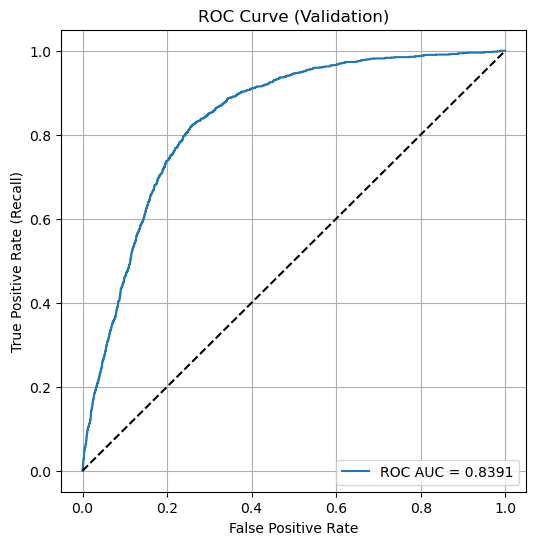

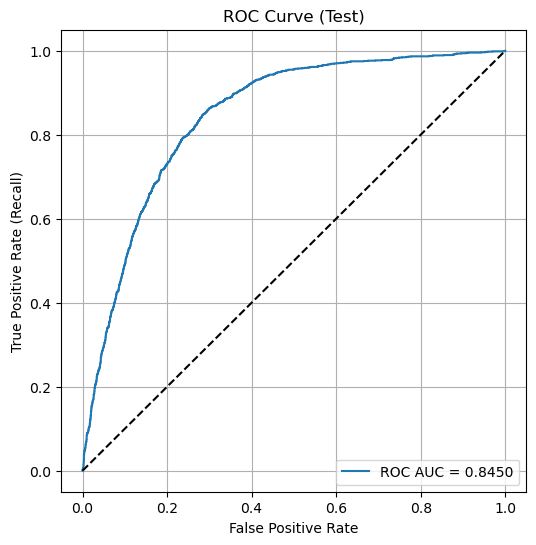

In [85]:
# Validation ROC
val_probs, val_labels = collect_probs_labels_binary(model, val_loader)
val_auc = plot_roc_curve(val_probs, val_labels, title="ROC Curve (Validation)")

# Test ROC
test_probs, test_labels = collect_probs_labels_binary(model, test_loader)
test_auc = plot_roc_curve(test_probs, test_labels, title="ROC Curve (Test)")

In [76]:
ckpt = torch.load("best_model.pt", map_location=device)  # 네가 저장한 방식에 맞춰서
model.load_state_dict(ckpt['state_dict'] if 'state_dict' in ckpt else ckpt)

# 평가
best_t, val_m, test_m = evaluate_with_threshold_search(
    model, val_loader, test_loader, t_min=0.1, t_max=0.9, steps=33, verbose=True
)

C:\Users\user\AppData\Local\Temp\ipykernel_9872\1890518590.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_model.pt", map_location=device)  # 네가 

[VAL] Best threshold: 0.550
[VAL] F1=0.5789  Precision=0.4772  Recall=0.7358  PR-AUC=0.5183
[TEST] Using th=0.550
[TEST] F1=0.5815  Precision=0.4882  Recall=0.7191  PR-AUC=0.5358


In [1]:
from sklearn.metrics import accuracy_score

# 확률과 라벨 수집
test_probs, test_labels = collect_probs_labels_binary(model, test_loader)

# threshold (val에서 찾은 best_t 사용)
best_t = 0.5  # 예시 (실제로는 evaluate_with_threshold_search에서 찾은 값 사용)
test_preds = (test_probs >= best_t).astype(int)

# 정확도 계산
acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {acc:.4f}")

NameError: name 'collect_probs_labels_binary' is not defined

In [45]:

from sklearn.metrics import classification_report

all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_onehot = batch['input_onehot'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()    # (B, 3)
        logits = model(input_onehot, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()  # (B, 3)
        all_labels.append(labels)
        all_probs.append(probs)

all_labels = np.concatenate(all_labels, axis=0)   # (N, 3)
all_probs  = np.concatenate(all_probs, axis=0)    # (N, 3)

print('all_labels:', all_labels.shape)
print('all_probs:', all_probs.shape)

for threshold in [0.6, 0.5, 0.4, 0.3, 0.2]:
    preds = (all_probs >= threshold).astype(int)
    print(f"\n=== Threshold {threshold} ===")
    print('preds:', preds.shape)
    print(classification_report(all_labels, preds, target_names=['Endosperm', 'Leaf_mean', 'Embryo_mean']))


all_labels: (6616, 3)
all_probs: (6616, 3)

=== Threshold 0.6 ===
preds: (6616, 3)
              precision    recall  f1-score   support

   Endosperm       0.72      0.41      0.53      2306
   Leaf_mean       0.66      0.52      0.58      1967
 Embryo_mean       0.71      0.39      0.51      2315

   micro avg       0.70      0.44      0.54      6588
   macro avg       0.70      0.44      0.54      6588
weighted avg       0.70      0.44      0.53      6588
 samples avg       0.19      0.18      0.17      6588


=== Threshold 0.5 ===
preds: (6616, 3)
              precision    recall  f1-score   support

   Endosperm       0.65      0.72      0.68      2306
   Leaf_mean       0.58      0.78      0.67      1967
 Embryo_mean       0.65      0.71      0.68      2315

   micro avg       0.63      0.74      0.68      6588
   macro avg       0.63      0.74      0.68      6588
weighted avg       0.63      0.74      0.68      6588
 samples avg       0.28      0.32      0.28      6588


=== Th

C:\Users\user\AnaConda\AC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AnaConda\AC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AnaConda\AC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AnaConda\AC\Lib\site-pac

In [46]:
import numpy as np

test_loss = 0
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_onehot'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        test_loss += loss.item()
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# 결과를 numpy로 합치기
logits = np.concatenate(all_logits, axis=0)
labels = np.concatenate(all_labels, axis=0)

# sigmoid 확률 → 0.5 이상이면 1, 미만이면 0
probs = 1 / (1 + np.exp(-logits))
preds = (probs >= 0.5).astype(int)

# 정확도(전체, 개별 클래스별)
acc_total = (preds == labels).mean()
acc_per_label = (preds == labels).mean(axis=0)
print(f"Test Accuracy (전체 평균): {acc_total:.4f}")
print(f"Test Accuracy (Endosperm, Leaf_mean, Embryo_mean): {acc_per_label}")

# 필요하면 precision, recall, f1-score 등도 sklearn.metrics로 계산 가능
print(classification_report(labels, preds, target_names=['Endosperm', 'Leaf_mean', 'Embryo_mean']))


Test Loss: 0.1298
Test Accuracy (전체 평균): 0.7663
Test Accuracy (Endosperm, Leaf_mean, Embryo_mean): [0.76723096 0.76617291 0.76556832]
              precision    recall  f1-score   support

   Endosperm       0.65      0.72      0.68      2306
   Leaf_mean       0.58      0.78      0.67      1967
 Embryo_mean       0.65      0.71      0.68      2315

   micro avg       0.63      0.74      0.68      6588
   macro avg       0.63      0.74      0.68      6588
weighted avg       0.63      0.74      0.68      6588
 samples avg       0.28      0.32      0.28      6588



C:\Users\user\AnaConda\AC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AnaConda\AC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AnaConda\AC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# 2) 샘플 단위 F1 기준으로 최적 threshold 탐색
def find_best_threshold_samples(val_probs, val_labels, start=0.1, end=0.7, step=0.05):
    ths = np.arange(start, end, step)
    best_th, best_f1 = 0.5, -1
    for th in ths:
        y_pred = (val_probs >= th).astype(int)
        f1 = f1_score(val_labels, y_pred, average='samples', zero_division=0)
        if f1 > best_f1:
            best_f1, best_th = f1, th
    return best_th, best_f1

# === 실행 ===
val_probs, val_labels   = collect_probs_labels(model, val_loader)
test_probs, test_labels = collect_probs_labels(model, test_loader)

best_th, best_val_f1 = find_best_threshold_samples(val_probs, val_labels,
                                                   start=0.2, end=0.6, step=0.05)
print(f"Best global threshold (samples F1 기준): {best_th:.2f}, "
      f"Val samples F1={best_val_f1:.4f}")

# 테스트에 적용
test_preds = (test_probs >= best_th).astype(int)

# 보고서
print(classification_report(
    test_labels, test_preds,
    target_names=['Endosperm','Leaf_mean','Embryo_mean'],
    zero_division=0
))

# F1 점수 요약
for avg in ['micro','macro','weighted','samples']:
    f1 = f1_score(test_labels, test_preds, average=avg, zero_division=0)
    print(f"{avg} F1: {f1:.4f}")


Best global threshold (samples F1 기준): 0.20, Val samples F1=0.3699
              precision    recall  f1-score   support

   Endosperm       0.43      0.98      0.59      2306
   Leaf_mean       0.36      0.98      0.52      1967
 Embryo_mean       0.43      0.98      0.60      2315

   micro avg       0.40      0.98      0.57      6588
   macro avg       0.40      0.98      0.57      6588
weighted avg       0.41      0.98      0.57      6588
 samples avg       0.33      0.46      0.37      6588

micro F1: 0.5724
macro F1: 0.5719
weighted F1: 0.5745
samples F1: 0.3665


In [ ]:
#전과정 설명 모델구성, 평가 지표 수식포함 설명

In [ ]:
#마스크 추가, 2.5->2, 가중치 바꿈